# Model for Price & Sales Prediction
### About the data
- this is a car purchase transaction from carvana website
- the dataset has 44k++ records with 13 columns
- the time range is the whole August 2022, daily data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
# read 
df = pd.read_csv('carvana_sold.csv')
print(df.shape)
df.head()

(44365, 13)


,vehicle_id,stock_number,year,make,model,miles,trim,sold_price,discounted_sold_price,partnered_dealership,delivery_fee,earliest_delivery_date,sold_date
0,2270123,2001646447,2014,Volkswagen,Jetta,53238,2.0L S,15990,15990,False,1490,2022-09-09T21:34:31.376Z,2022-08-31
1,2298228,2001690283,2015,Chevrolet,Volt,112160,base,17590,17590,False,790,2022-09-09T22:04:42.555Z,2022-08-31
2,2463098,2001933427,2015,Ford,Focus,57046,SE,14990,14990,False,0,2022-09-06T21:35:20.3145311Z,2022-08-31
3,2488480,2001977729,2013,Honda,Odyssey,103874,EX-L,18990,18990,False,490,2022-09-06T22:04:19.711928Z,2022-08-31
4,2183400,2001531442,2015,Chevrolet,Cruze,86301,1LT,13990,13990,False,790,2022-09-09T22:05:19.367Z,2022-08-31


In [3]:
df.dtypes

vehicle_id                 int64
stock_number               int64
year                       int64
make                      object
model                     object
miles                      int64
trim                      object
sold_price                 int64
discounted_sold_price      int64
partnered_dealership        bool
delivery_fee               int64
earliest_delivery_date    object
sold_date                 object
dtype: object

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44365 entries, 0 to 44364
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   vehicle_id              44365 non-null  int64 
 1   stock_number            44365 non-null  int64 
 2   year                    44365 non-null  int64 
 3   make                    44365 non-null  object
 4   model                   44365 non-null  object
 5   miles                   44365 non-null  int64 
 6   trim                    44365 non-null  object
 7   sold_price              44365 non-null  int64 
 8   discounted_sold_price   44365 non-null  int64 
 9   partnered_dealership    44365 non-null  bool  
 10  delivery_fee            44365 non-null  int64 
 11  earliest_delivery_date  44365 non-null  object
 12  sold_date               44365 non-null  object
dtypes: bool(1), int64(7), object(5)
memory usage: 4.1+ MB


- ignore vehicle_id, stock_number, discounted_sold_price
- not gonna use earliest_delivery_date as well
- data is considered clean

# Price Prediction

- this model intends to predict the price of each model, so we can give a suggestion to those who sell it whether they sey at the reasonable price or not
- from descriptive exploration we have an insight that several models tend to have a potential sales (high GMV but low sales)
- those models also tend to have a high sell price, but the range sell price is vary
- feature used: year, miles, make, model, and trim

In [73]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

In [13]:
df.head()

,vehicle_id,stock_number,year,make,model,miles,trim,sold_price,discounted_sold_price,partnered_dealership,delivery_fee,earliest_delivery_date,sold_date
0,2270123,2001646447,2014,Volkswagen,Jetta,53238,2.0L S,15990,15990,False,1490,2022-09-09T21:34:31.376Z,2022-08-31
1,2298228,2001690283,2015,Chevrolet,Volt,112160,base,17590,17590,False,790,2022-09-09T22:04:42.555Z,2022-08-31
2,2463098,2001933427,2015,Ford,Focus,57046,SE,14990,14990,False,0,2022-09-06T21:35:20.3145311Z,2022-08-31
3,2488480,2001977729,2013,Honda,Odyssey,103874,EX-L,18990,18990,False,490,2022-09-06T22:04:19.711928Z,2022-08-31
4,2183400,2001531442,2015,Chevrolet,Cruze,86301,1LT,13990,13990,False,790,2022-09-09T22:05:19.367Z,2022-08-31


<Axes: >

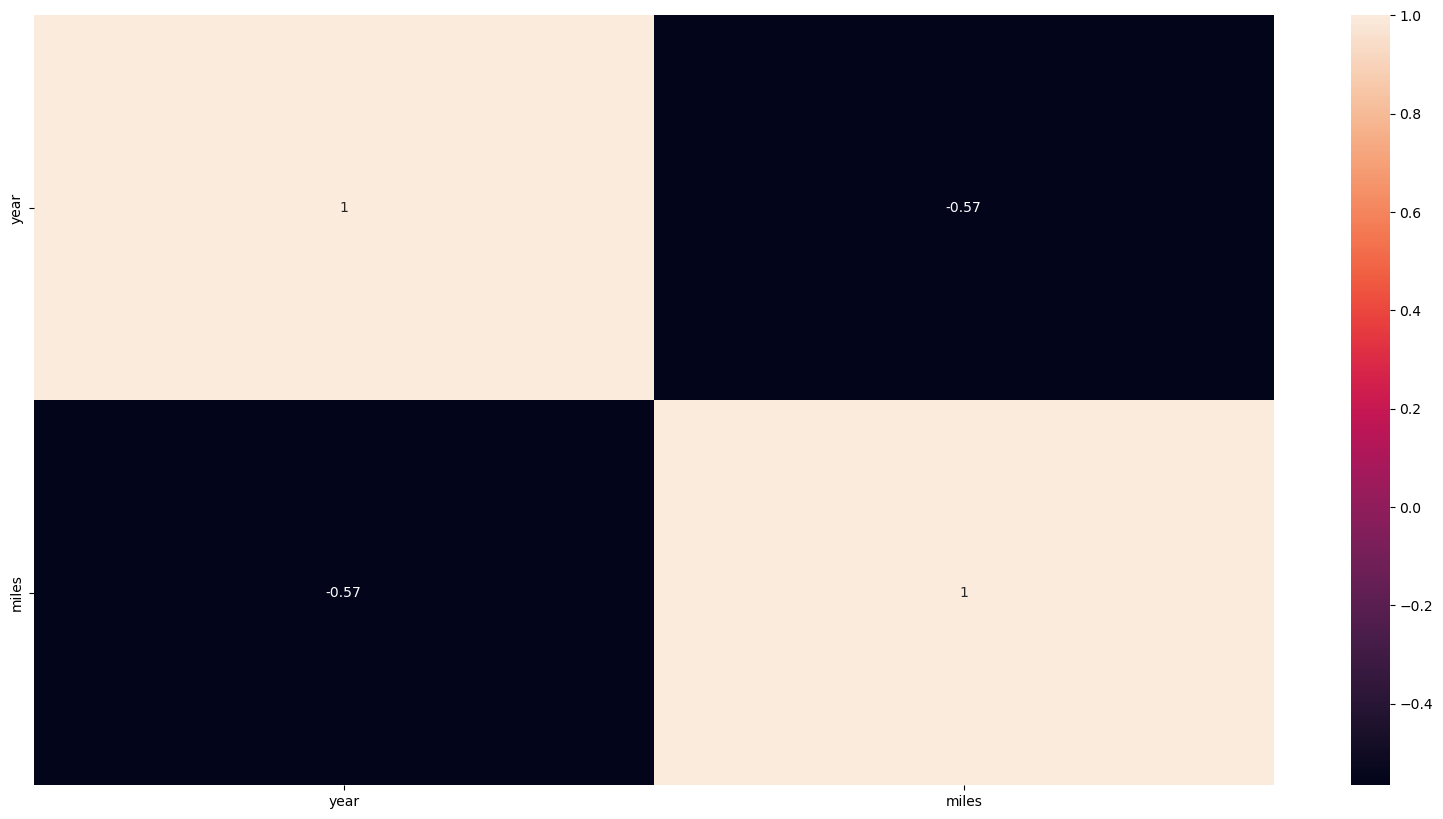

In [16]:
# see correlation between numerical variables
plt.figure(figsize=(20,10))
sns.heatmap(df[["year","miles"]].corr(), annot=True)

In [19]:
# Use label encoder for categorical variables
lb = LabelEncoder()

In [20]:
df['make'] = lb.fit_transform(df['make'])
df['model'] = lb.fit_transform(df['model'])
df['trim'] = lb.fit_transform(df['trim'])

In [21]:
# set features
X = df[["year","miles","make","model","trim"]]
y = df['sold_price']

In [23]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [88]:
reg_list = [["GradientBoostingRegressor",GradientBoostingRegressor()], 
              ["RandomForestRegressor",RandomForestRegressor()],
              ["SupportVectorRegression", SVR()],
              ["LinearRegression", LinearRegression()],
              ["DecisionTreeRegressor", DecisionTreeRegressor()],
              ["BayesianRidge",BayesianRidge()]]

In [101]:
kfold = 5
df_res = pd.DataFrame()

In [103]:
# loop for modelling
for i in reg_list:
    rg_name = i[0]
    rg = i[1]
    result_mse = np.array([])
    result_rmse = np.array([])
    result_r2 = np.array([])
    for k in range(kfold):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        rg_fit = rg.fit(X_train,y_train)
    
        #Predicting
        rg_predict = rg.predict(X_test)
        
        #Calculating the Mean Square error, root mean square error, R2-Score
        result_mse = np.append(result_mse, metrics.mean_squared_error(y_test, rg_predict))
        result_rmse = np.append(result_rmse, np.sqrt(metrics.mean_squared_error(y_test, rg_predict)))
        result_r2 = np.append(result_r2, metrics.r2_score(y_test, rg_predict))
    
    print('Result ', rg_name)
    print('Avg MSE: ', round(result_mse.mean(),4))
    print('Avg RMSE: ', round(result_rmse.mean(),4))
    print("Avg R2 score: ", round(result_r2.mean(), 4))
    df_temp = pd.DataFrame([[rg_name,round(result_mse.mean(),4),round(result_rmse.mean(),4),round(result_r2.mean(), 4)]],
                   columns=['Regressor Name', 'MSE', 'RMSE', 'R2'])
    df_res = pd.concat([df_res, df_temp])

Result  GradientBoostingRegressor
Avg MSE:  35157184.6482
Avg RMSE:  5929.2476
Avg R2 score:  0.6833
Result  RandomForestRegressor
Avg MSE:  12829254.3486
Avg RMSE:  3578.9946
Avg R2 score:  0.8855
Result  SupportVectorRegression
Avg MSE:  98095468.9424
Avg RMSE:  9903.9144
Avg R2 score:  0.11
Result  LinearRegression
Avg MSE:  68835056.1158
Avg RMSE:  8296.5342
Avg R2 score:  0.3792
Result  DecisionTreeRegressor
Avg MSE:  23919529.1543
Avg RMSE:  4888.7138
Avg R2 score:  0.7865
Result  BayesianRidge
Avg MSE:  70360118.992
Avg RMSE:  8387.8121
Avg R2 score:  0.3739


In [305]:
df_res

,Regressor Name,MSE,RMSE,R2
0,GradientBoostingRegressor,3.515718e+07,5929.2476,0.6833
0,RandomForestRegressor,1.282925e+07,3578.9946,0.8855
0,SupportVectorRegression,9.809547e+07,9903.9144,0.1100
0,LinearRegression,6.883506e+07,8296.5342,0.3792
0,DecisionTreeRegressor,2.391953e+07,4888.7138,0.7865
0,BayesianRidge,7.036012e+07,8387.8121,0.3739


<Axes: xlabel='Regressor Name', ylabel='R2'>

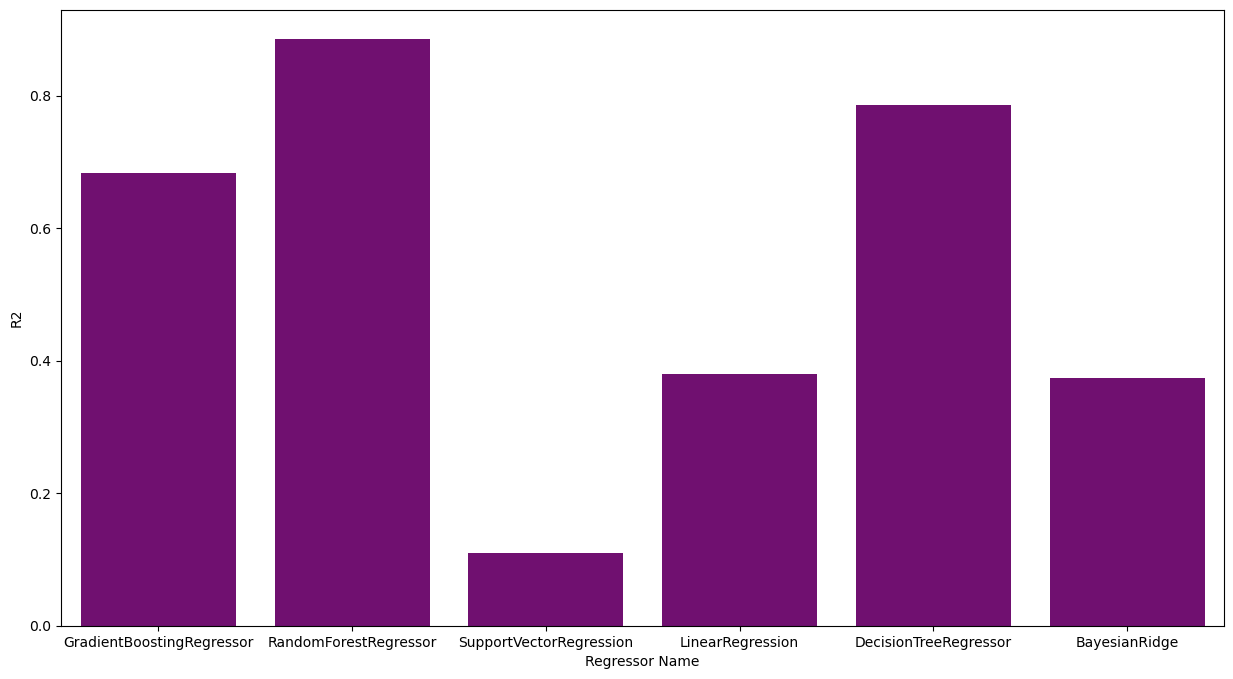

In [297]:
# create chart
plt.figure(figsize=(15, 8))
sns.barplot(data=df_res, x="Regressor Name", y="R2", color="purple")

- from the result, the best regressor is Random Forest because it has the higher R2 score (0.881) and lowest mean squared error score (3,672)
- we can use the model to predict the price for pricing recommendation
- to do next: to enhance the model accuracy, we can do
    - add data points
    - do the hypertuning for the model (in order to speed up the model as well)
    - add more features

# Sales Prediction

- this model intends to predict the sales over the time in the future
- feature used: sold date and several customized columns
- limitation: only 1 month data in daily granularity, so we can only predict several upcoming days

In [239]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

In [135]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2022-08-01 to 2022-08-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_sales  30 non-null     int64
dtypes: int64(1)
memory usage: 480.0 bytes


In [109]:
# change date datatype
df['sold_date'] = pd.to_datetime(df['sold_date'])

In [131]:
# set date as index
df_new = df['sold_date'].value_counts().to_frame('total_sales').sort_index()

In [144]:
# set data frequency
df_new = df_new.asfreq('d')

In [147]:
# drop null values
df_new = df_new.fillna(0)

In [240]:
# add to STL model
stl = STL(df_new['total_sales'], seasonal=7)  
result = stl.fit()

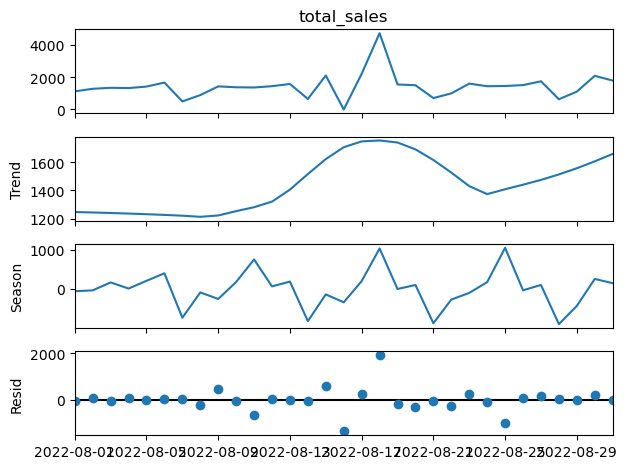

In [241]:
fig = result.plot()
plt.show()

In [242]:
# assume there is weekly seasonality
season_prd = result.seasonal

In [243]:
# add forecast length, adjust date based on forecast length
forecast_length = 7  
forecast_dates = pd.date_range(start=df_new.index.max() + pd.DateOffset(1), periods=forecast_length)
forecast = result.trend.iloc[-1] + seasonal_forecast[-forecast_length:]

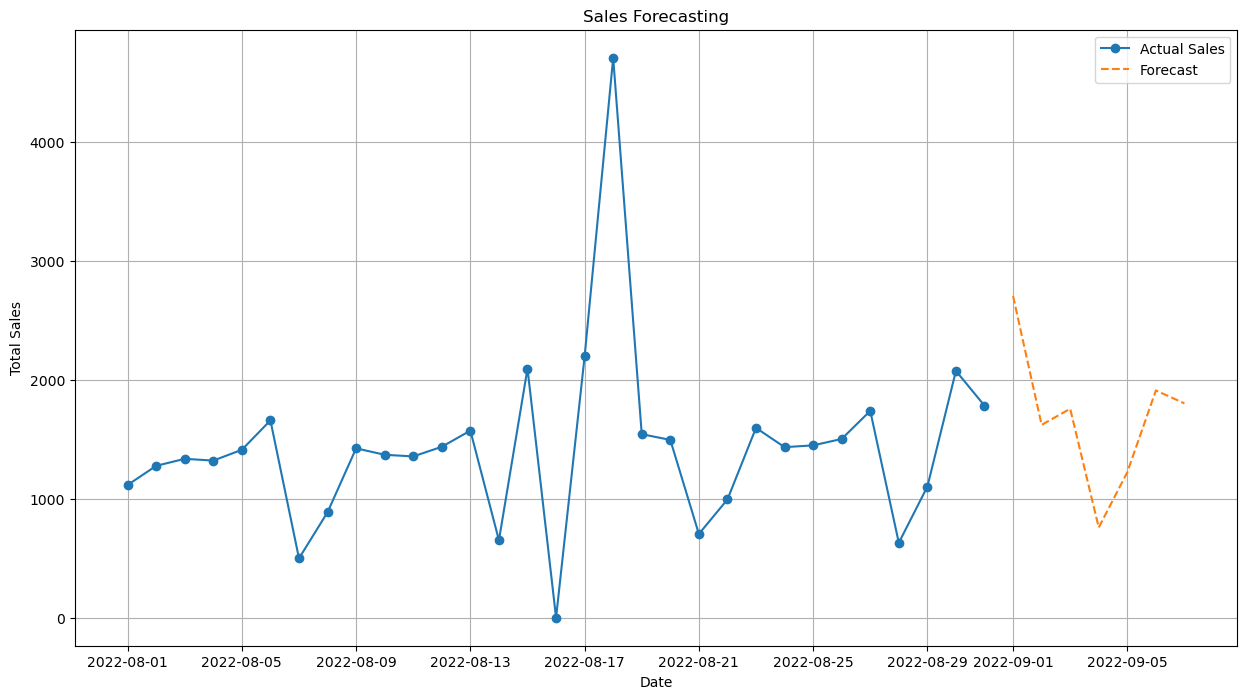

In [246]:
# Plot the actual sales data, forecast, and components
plt.figure(figsize=(15, 8))
plt.plot(df_new.index, df_new['total_sales'], label='Actual Sales', marker='o')
plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Forecasting')
plt.legend()
plt.grid(True)
plt.show()

In [250]:
# check accuracy
train = df_new[:20]
test = df_new[20:]

In [265]:
#Calculating the Mean Square error, root mean square error
print ("MSE: ", np.mean(np.abs(test['total_sales'] - forecast_tr)))
print ("RMSE ",np.sqrt(np.mean((test['total_sales'] - forecast_tr)**2)))

MSE:  560.7989114729676
RMSE  669.9691827911856


In [281]:
df_stl = pd.DataFrame()

In [283]:
for i in [3,5,7,9,11,13]:
    stl_tr = STL(train['total_sales'], seasonal=i)  
    result_tr = stl_tr.fit()

    season_prd_tr = result_tr.seasonal
    forecast_length_tr = 11  
    forecast_dates_tr = pd.date_range(start=train.index.max() + pd.DateOffset(1), periods=forecast_length_tr)
    forecast_tr = result_tr.trend.iloc[-1] + seasonal_forecast[-forecast_length_tr:]
    
    print("For seasonal:",i)
    print ("MSE: ", np.mean(np.abs(test['total_sales'] - forecast_tr)))
    print ("RMSE ",np.sqrt(np.mean((test['total_sales'] - forecast_tr)**2)))
    
    df_temp_stl = pd.DataFrame([[i,round(np.mean(np.abs(test['total_sales'] - forecast_tr)),4),round(np.sqrt(np.mean((test['total_sales'] - forecast_tr)**2)),4)]],
                   columns=['Seasonal','MSE', 'RMSE'])
    df_stl = pd.concat([df_stl, df_temp_stl])

For seasonal: 3
MSE:  560.7989114729676
RMSE  669.9691827911856
For seasonal: 5
MSE:  633.8030427955622
RMSE  732.1677293062958
For seasonal: 7
MSE:  678.5715760354568
RMSE  771.2474768735827
For seasonal: 9
MSE:  712.683997531656
RMSE  801.4248356011469
For seasonal: 11
MSE:  712.5788838428524
RMSE  801.3313624708253
For seasonal: 13
MSE:  712.5038772596789
RMSE  801.2646640721775


<Axes: xlabel='Seasonal', ylabel='MSE'>

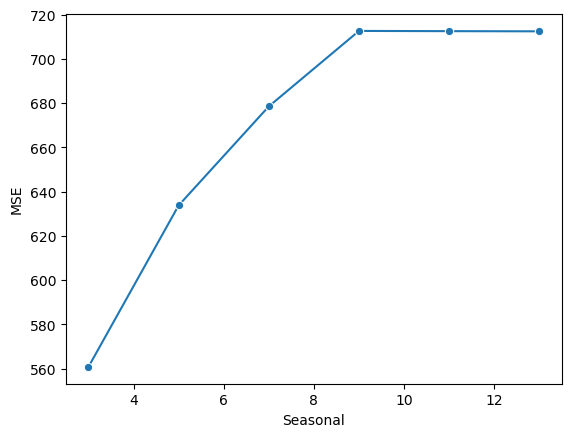

In [291]:
sns.lineplot(data=df_stl, x="Seasonal", y="MSE", marker='o')

- based on the iteration, we will set 3 as the seasonal param

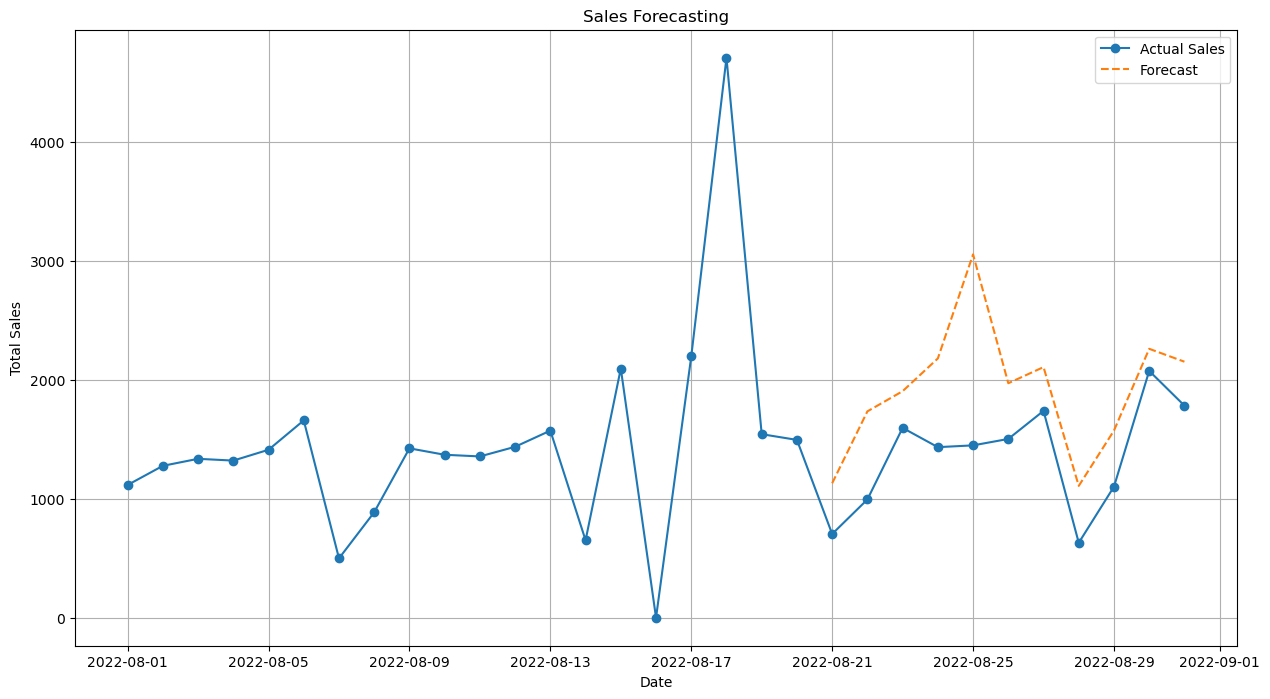

In [260]:
# add to STL model
stl_tr = STL(train['total_sales'], seasonal=3)  
result_tr = stl_tr.fit()

season_prd_tr = result_tr.seasonal
forecast_length_tr = 11  
forecast_dates_tr = pd.date_range(start=train.index.max() + pd.DateOffset(1), periods=forecast_length_tr)
forecast_tr = result_tr.trend.iloc[-1] + seasonal_forecast[-forecast_length_tr:]

# Plot the actual sales data, forecast, and components
plt.figure(figsize=(15, 8))
plt.plot(df_new.index, df_new['total_sales'], label='Actual Sales', marker='o')
plt.plot(forecast_dates_tr, forecast_tr, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Forecasting')
plt.legend()
plt.grid(True)
plt.show()

#### limitation and to-do next
- the data points are limited, need to use bigger data
- if we have a bigger dataset we can consider using model like ARMA for forecasting
- can predict sales for each specific model

In [302]:
tmp = pd.DataFrame(forecast_tr).rename(columns={"season": "forecast_total_sales"})

In [303]:
df_all = pd.concat([df_new, tmp])

In [304]:
df_all.to_excel("data_sales_forecast.xlsx")